## 0) Download the data

In [ ]:
!gdown https://drive.google.com/file/d/1_gfqZRLUoVBO-5VAwzyEd22teuCdtGSB/view?usp=sharing

## 1) Import needed libraries and install dependencies


In [ ]:
!pip install torch torchvision -q

In [ ]:
!pip install pytorch-lightning -q

In [ ]:
!pip install rasterio -q

In [ ]:
import os
import urllib.request

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from PIL import Image
import rasterio
import folium
import glob
import IPython.display as disp

%matplotlib inline


## 2) Create Dataset class

In [ ]:
class S12MSDataset(Dataset):
    """
    Dataset class to be used in a DataLoader to create batches.
    This class reads .tif images from a given directory and applies optional 
    transformations.

    Attributes:
        root_dir (str): A directory path where the images are stored.
        transform (callable, optional): Optional transform to be applied on an image.

    Methods:
        get_image_paths(): Retrieves all image paths in the given directory.
        __len__(): Returns the total number of images.
        __getitem__(idx): Gets the image (and its copy) at index 'idx'.
    """

      def __init__(self, root_dir, transform=None):
          """
          Args:
            root_dir (str): A directory path where the images are stored.
            transform (callable, optional): Optional transform to be applied on an image.
          """
          self.root_dir = root_dir
          self.transform = transform
          self.image_paths = self.get_image_paths()

      def get_image_paths(self):
          """
          Retrieves all image paths in the given directory ending with '.tif'.
          
          Returns:
              list: A list of all image paths.
          """
          image_paths = []
          for subdir, dirs, files in os.walk(self.root_dir):
              for file in files:
                  if file.endswith('.tif'):
                      image_paths.append(os.path.join(subdir, file))
          return image_paths

      def __len__(self):
          """
          Returns the total number of images.
          
          Returns:
              int: The total number of images.
          """
          return len(self.image_paths)

      def __getitem__(self, idx):
          """
          Gets the image (and its copy) at index 'idx'.
          
          Args:
              idx (int): The index of the image.

          Returns:
              tuple: A tuple containing an image and its copy.

          Raises:
              IndexError: If idx is out of bounds.
          """
          if idx < 0 or idx >= len(self.image_paths):
              raise IndexError(f"Index {idx} is out of range. Valid indices are between 0 and {len(self.image_paths) - 1}.")

          image_path = self.image_paths[idx]
          with rasterio.open(image_path) as src:
              image = src.read(1)

          image = Image.fromarray(image)

          if self.transform:
              image = self.transform(image)

          return image, image

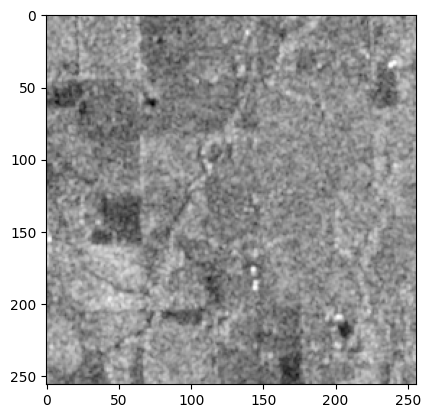

In [ ]:
# define path containing the images
root_dir = '/content/s12ms_subset'

transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

dataset = S12MSDataset(root_dir, transform=transform)

# Choose an image index to visualize
image_index = 100
image, _ = dataset[image_index]  

# Convert the PyTorch tensor to a numpy array and remove the channel dimension
image_np = image.squeeze(0).squeeze(0).numpy()

# Display the image as a grayscale image
plt.imshow(image_np, cmap='gray')
plt.show()


## 3) Create Model class

In [ ]:
class ResidualBlock(nn.Module):
    """
    A ResidualBlock class which serves as a basic building block for the convolutional neural network. 
    It consists of two convolutional layers with a skip connection, along with Batch Normalization 
    and ReLU activation functions after each convolutional layer.

    Attributes:
        conv1, conv2 (nn.Conv2d): Convolutional layers with kernel size 3 and padding 1. 
                                  The first layer converts the number of channels from `in_channels` to `out_channels`, 
                                  the second one keeps the same number of output channels.
        bn1, bn2 (nn.BatchNorm2d): Batch normalization layers. Normalizes the outputs of the convolutional layers.
        relu1 (nn.ReLU): ReLU activation function. Applies a non-linear transformation to the outputs of the batch normalization layers.

    Methods:
        forward(x: Tensor) -> Tensor: Defines the forward pass through the block. Adds the input to the output of the block (skip connection).
    """

    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        return out

class SpeckleReducer(pl.LightningModule):
    """
    The SpeckleReducer class represents the main model to be used for speckle reduction in images. 
    It follows an encoder-decoder structure with a bottleneck that includes residual blocks.

    Attributes:
        encoder (nn.Sequential): The encoder part of the model, which downsamples the input using convolutional layers and max pooling.
        middle (nn.Sequential): The middle part of the model, consisting of residual blocks to extract more detailed features.
        decoder (nn.Sequential): The decoder part of the model, which upsamples the features back to the original image size using convolutional layers and upsampling.
        ...

    Methods:
        forward(x: Tensor) -> Tensor: Defines the forward pass of the model. It passes the input through the encoder, middle, and decoder parts sequentially.

        training_step(train_batch: Tuple[Tensor, Tensor], batch_idx: int) -> Tensor: Defines a single step during training. 
                                                                                    Computes the MSE loss between the model's outputs and the target values.

        validation_step(val_batch: Tuple[Tensor, Tensor], batch_idx: int): Calculates and logs the validation loss.

        configure_optimizers() -> optim.Adam: Defines the Adam optimizer for the model with learning rate 0.001 and weight decay 1e-4.
    """

    def __init__(self):
        super(S12MS, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
        )

        # bottleneck -> use residual blocks to add features
        self.middle = nn.Sequential(
            ResidualBlock(256, 256),
            ResidualBlock(256, 256),
        )

        self.decoder = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        return x3

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('train_loss', loss, prog_bar=True, on_step=False,
                 on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_hat = self.forward(x)
        loss = nn.MSELoss()(y_hat, y)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, 
                 logger=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001,
                               weight_decay=1e-4)
        return optimizer

## 4) Train model

In [ ]:
# Load the dataset
root_dir = '/content/s12ms_subset'

transform = transforms.Compose([
    transforms.CenterCrop(200),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

dataset = S12MSDataset(root_dir, transform=transform)

# Perform the random split
train_set, valid_set, test_set = random_split(dataset, 
                [0.6, 0.2, 0.2])

In [ ]:
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs):
    
    # define model and checkpoints
    checkpoint_callback = ModelCheckpoint(
        monitor='train_loss',
        save_top_k=1,
        save_last=True,
        mode='min',
        filename='speckle_reducer_{epoch:02d}_{train_loss:.4f}'
    )

    # define trainer
    trainer = Trainer(
        max_epochs=num_epochs,
        accelerator='gpu',
        devices=1,
        callbacks=[checkpoint_callback]
    )

    # start training
    trainer.fit(model, train_dataloaders=train_loader,
                val_dataloaders=val_loader)

    return model

In [ ]:
epochs = 20
model = SpeckleReducer()

# Train the model
model = train_model(model, train_loader, valid_loader, epochs)

## 5) Test model and export images

In [ ]:
def visualize_denoising(model, test_loader, path, num_examples=5):
    model.eval()  # Set the model to evaluation mode

    # Create a figure to display the images
    fig, axs = plt.subplots(num_examples, 2, figsize=(10, 3*num_examples))
    fig.suptitle("Noisy vs Denoised Images")

    # Iterate through the test loader to get example images
    for i, (noisy, _) in enumerate(test_loader):
        if i >= num_examples:
            break

        # Pass the noisy image through the model 
        with torch.no_grad():
            denoised = model(noisy)

        # Convert the tensors to numpy arrays and remove the channel dimension
        noisy_np = noisy.numpy()
        noisy_np = noisy_np[0, 0, :, :]
        denoised_np = denoised.numpy()
        denoised_np = denoised_np[0, 0, :, :]

        # Save the noisy image as .tif
        with rasterio.open(f'{path}/noisy_image{i}.tif', 'w', driver='GTiff', 
                        height=noisy_np.shape[0], 
                        width=noisy_np.shape[1], 
                        count=1, dtype=noisy_np.dtype) as dst:
          dst.write(noisy_np, 1)

        # Save the denoised image as .tif
        with rasterio.open(f'{path}/denoised_image{i}.tif', 'w', driver='GTiff', 
                           height=denoised_np.shape[0], 
                           width=denoised_np.shape[1], 
                           count=1, dtype=denoised_np.dtype) as dst:
            dst.write(denoised_np, 1)

        # Plot the noisy and denoised images
        axs[i, 0].imshow(noisy_np, cmap='gray')
        axs[i, 0].set_title(f'Noisy Image {i+1}')
        axs[i, 1].imshow(denoised_np, cmap='gray')
        axs[i, 1].set_title(f'Denoised Image {i+1}')
        axs[i, 0].axis('off')
        axs[i, 1].axis('off')

    # Show the figure
    plt.tight_layout()
    plt.show()

# Test the model and visualize examples
# TODO: define the path!
visualize_denoising(model, test_loader, path='...')
